<a href="https://colab.research.google.com/github/RohanHanda/NLPUsingDL/blob/main/GloveUsingALS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import sys
import string
import operator

In [2]:
sys.path.append(os.path.abspath('/content/drive/MyDrive/Colab Notebooks'))

In [3]:
from datetime import datetime
from sklearn.utils import shuffle

In [4]:
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import cosine as cos_dist

In [5]:
from machine_learning_examples.nlp_class2.util import find_analogies

In [6]:
class glove:
  def __init__(self,D,V,context_sz):
    self.D = D
    self.V = V
    self.context_sz = context_sz
  def fit(self,sentences, cc_matrix = None, learning_rate = 10e-5, reg = 0.1, xmax=100,alpha=0.75,epochs=10,gd=False):
    t0 = datetime.now()
    V = self.V
    D = self.D
    if not os.path.exists(cc_matrix):
      X = np.zeros((V,V))
      N =  len(sentences)
      print("Number of sentences to process is ",N)
      it = 0
      for sentence in sentences:
        it+=1
        if it%10000 == 0:
          print("Processed ",it,"/",N)
        n = len(sentence)
        for i in range(n):
          wi = sentence[i]
          start = max(0,i-self.context_sz)
          end = min(n,i+self.context_sz+1)

          if i-self.context_sz <0:
            points = 1.0/(i+1)
            X[wi,0] += points
            X[0,wi] += points
          if i+self.context_sz >n:
            points = 1.0/(n-i)
            X[wi,1] += points
            X[1,wi] += points

          for j in range(start,i):
            wj = sentence[j]
            points = 1.0/(i-j)
            X[wi,wj] += points
            X[wj,wi] += points
          for j in range(i+1,end):
            wj = sentence[j]
            points = 1.0/(j-i)
            X[wi,wj] += points
            X[wj,wi] += points
      np.save(cc_matrix,X)
    else:
      X = np.load(cc_matrix)
    print("Max Value of X",X.max())
    fX = np.zeros((V,V))
    fX[X<xmax] = (X[X<xmax]/float(xmax))**alpha
    fX[X>=xmax] = 1

    logX = np.log(X+1)
    print("Time taken to build co-occurence matrix",datetime.now()-t0)


    W = np.random.rand(V,D)/np.sqrt(V+D)
    b = np.zeros(V)
    U = np.random.rand(V,D)/np.sqrt(V+D)
    c = np.zeros(V)
    mu = logX.mean()

    costs = []
    sentence_indexes = range(len(sentences))
    for epoch in range(epochs):
      delta = W.dot(U.T) + b.reshape(V,1)+c.reshape(1,V)+mu-logX
      cost = (fX*delta*delta).sum()
      costs.append(cost)
      print("epoch: ",epoch,"cost: ",cost)
      if gd:
          oldW = W.copy()
          for i in range(V):
            W[i]-=learning_rate*(fX[i,:]*delta[i,:]).dot(U)
          W -= learning_rate*reg*W

          for i in range(V):
            b[i] -= learning_rate*fX[i,:].dot(delta[i,:])
          b -= learning_rate*reg*b

          for j in range(V):
            U[j]-=learning_rate*(fX[:,j]*delta[:,j]).dot(oldW)
          U -= learning_rate*reg*U

          for j in range(V):
            c[j] -= learning_rate*fX[:,j].dot(delta[:,j])
          c -= learning_rate*reg*c
      else:
        for i in range(V):
          matrix = reg*np.eye(D)+(fX[i,:]*U.T).dot(U)
          vector = (fX[i,:]*(logX[i,:]-b[i]-c-mu)).dot(U)
          W[i] = np.linalg.solve(matrix,vector)
        for i in range(V):
          denominator = fX[i,:].sum()
          numerator = fX[i,:].dot(logX[i,:] - W[i].dot(U.T) - c - mu)
          b[i] = numerator/denominator/(1+reg)
        for j in range(V):
          matrix = reg*np.eye(D)+(fX[:,j]*W.T).dot(W)
          vector = (fX[:,j]*(logX[:,j] - b- c[j]- mu)).dot(W)
          U[j] = np.linalg.solve(matrix,vector)
        for j in range(V):
          denominator = fX[:,j].sum()
          numerator = fX[:,j].dot(logX[:,j] - W.dot(U[j]) - b-mu)
          c[j] = numerator/denominator/(1+reg)
    self.W = W
    self.U = U
    plt.plot(costs)
    plt.show()

  def save(self, fn):
    arrays = [self.W, self.U.T]
    np.savez(fn, *arrays)

In [7]:
def remove_punctuation_2(s):
    return s.translate(None, string.punctuation)

def remove_punctuation_3(s):
    return s.translate(str.maketrans('','',string.punctuation))

if sys.version.startswith('2'):
    remove_punctuation = remove_punctuation_2
else:
    remove_punctuation = remove_punctuation_3

In [8]:
def my_tokenizer(s):
    s = remove_punctuation(s)
    s = s.lower() # downcase
    return s.split()

In [9]:
def get_wikipedia_data(n_files, n_vocab, by_paragraph=False):
    prefix = '/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/large_files/'

    if not os.path.exists(prefix):
        print("Are you sure you've downloaded, converted, and placed the Wikipedia data into the proper folder?")
        print("I'm looking for a folder called large_files, adjacent to the class folder, but it does not exist.")
        print("Please download the data from https://dumps.wikimedia.org/")
        print("Quitting...")
        exit()

    input_files = [f for f in os.listdir(prefix) if f.startswith('enwiki') and f.endswith('txt')]

    if len(input_files) == 0:
        print("Looks like you don't have any data files, or they're in the wrong location.")
        print("Please download the data from https://dumps.wikimedia.org/")
        print("Quitting...")
        exit()

    # return variables
    sentences = []
    word2idx = {'START': 0, 'END': 1}
    idx2word = ['START', 'END']
    current_idx = 2
    word_idx_count = {0: float('inf'), 1: float('inf')}

    if n_files is not None:
        input_files = input_files[:n_files]

    for f in input_files:
        print("reading:", f)
        for line in open(prefix + f):
            line = line.strip()
            # don't count headers, structured data, lists, etc...
            if line and line[0] not in ('[', '*', '-', '|', '=', '{', '}'):
                if by_paragraph:
                    sentence_lines = [line]
                else:
                    sentence_lines = line.split('. ')
                for sentence in sentence_lines:
                    tokens = my_tokenizer(sentence)
                    for t in tokens:
                        if t not in word2idx:
                            word2idx[t] = current_idx
                            idx2word.append(t)
                            current_idx += 1
                        idx = word2idx[t]
                        word_idx_count[idx] = word_idx_count.get(idx, 0) + 1
                    sentence_by_idx = [word2idx[t] for t in tokens]
                    sentences.append(sentence_by_idx)

    # restrict vocab size
    sorted_word_idx_count = sorted(word_idx_count.items(), key=operator.itemgetter(1), reverse=True)
    word2idx_small = {}
    new_idx = 0
    idx_new_idx_map = {}
    for idx, count in sorted_word_idx_count[:n_vocab]:
        word = idx2word[idx]
        print(word, count)
        word2idx_small[word] = new_idx
        idx_new_idx_map[idx] = new_idx
        new_idx += 1
    # let 'unknown' be the last token
    word2idx_small['UNKNOWN'] = new_idx
    unknown = new_idx

    assert('START' in word2idx_small)
    assert('END' in word2idx_small)
    assert('king' in word2idx_small)
    assert('queen' in word2idx_small)
    assert('man' in word2idx_small)
    assert('woman' in word2idx_small)

    # map old idx to new idx
    sentences_small = []
    for sentence in sentences:
        if len(sentence) > 1:
            new_sentence = [idx_new_idx_map[idx] if idx in idx_new_idx_map else unknown for idx in sentence]
            sentences_small.append(new_sentence)

    return sentences_small, word2idx_small

In [10]:
def main(we_file,w2i_file, n_files = 50):
  cc_matrix = "cc_matrix_%s.npy" % n_files
  if os.path.exists(cc_matrix):
    with open(w2i_file) as f:
      word2idx = json.load(f)
    sentences = []
  else:
    sentences,word2idx = get_wikipedia_data(n_files = n_files, n_vocab = 2000)
    with open(w2i_file,'w') as f:
      json.dump(word2idx,f)
  V = len(word2idx)
  model = glove(80,V,10)
  #model.fit(sentences = sentences, cc_matrix = cc_matrix, learning_rate = 3*10e-5, reg = 0.01,epochs = 2000,gd=True)
  model.fit(sentences, cc_matrix, learning_rate = 3*10e-5, reg = 0.01, epochs = 20)
  model.save(we_file)


reading: enwiki-20250620-pages-articles-multistream1-1.txt
reading: enwiki-20250620-pages-articles-multistream1-10.txt
reading: enwiki-20250620-pages-articles-multistream1-100.txt
reading: enwiki-20250620-pages-articles-multistream1-101.txt
reading: enwiki-20250620-pages-articles-multistream1-102.txt
reading: enwiki-20250620-pages-articles-multistream1-103.txt
reading: enwiki-20250620-pages-articles-multistream1-104.txt
reading: enwiki-20250620-pages-articles-multistream1-11.txt
reading: enwiki-20250620-pages-articles-multistream1-12.txt
reading: enwiki-20250620-pages-articles-multistream1-13.txt
reading: enwiki-20250620-pages-articles-multistream1-14.txt
reading: enwiki-20250620-pages-articles-multistream1-15.txt
reading: enwiki-20250620-pages-articles-multistream1-16.txt
reading: enwiki-20250620-pages-articles-multistream1-17.txt
reading: enwiki-20250620-pages-articles-multistream1-18.txt
reading: enwiki-20250620-pages-articles-multistream1-19.txt
reading: enwiki-20250620-pages-artic

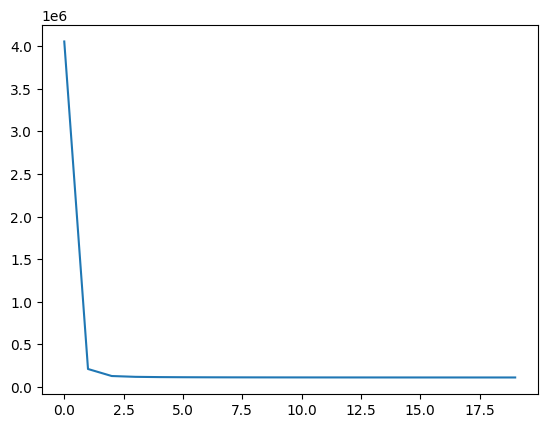

** concat: True
closest match by euclidean distance: emperor
king - man = emperor - woman
closest match by cosine distance: emperor
king - man = emperor - woman
closest match by euclidean distance: england
france - paris = england - london
closest match by cosine distance: england
france - paris = england - london
closest match by euclidean distance: italy
france - paris = italy - rome
closest match by cosine distance: italy
france - paris = italy - rome
closest match by euclidean distance: berlin
paris - france = berlin - italy
closest match by cosine distance: berlin
paris - france = berlin - italy
closest match by euclidean distance: england
france - french = england - english
closest match by cosine distance: england
france - french = england - english
closest match by euclidean distance: china
japan - japanese = china - chinese
closest match by cosine distance: china
japan - japanese = china - chinese
closest match by euclidean distance: italy
japan - japanese = italy - italian
cl

In [11]:
we = 'glove_model_50.npz'
w2i = 'glove_word2idx_50.json'
main(we,w2i)
npz = np.load(we)
W1 = npz['arr_0']
W2 = npz['arr_1']
with open(w2i) as f:
        word2idx = json.load(f)
        idx2word = {i:w for w,i in word2idx.items()}

for concat in (True, False):
  print("** concat:", concat)

  if concat:
      We = np.hstack([W1, W2.T])
  else:
      We = (W1 + W2.T) / 2


  find_analogies('king', 'man', 'woman', We, word2idx, idx2word)
  find_analogies('france', 'paris', 'london', We, word2idx, idx2word)
  find_analogies('france', 'paris', 'rome', We, word2idx, idx2word)
  find_analogies('paris', 'france', 'italy', We, word2idx, idx2word)
  find_analogies('france', 'french', 'english', We, word2idx, idx2word)
  find_analogies('japan', 'japanese', 'chinese', We, word2idx, idx2word)
  find_analogies('japan', 'japanese', 'italian', We, word2idx, idx2word)
  find_analogies('japan', 'japanese', 'australian', We, word2idx, idx2word)
  find_analogies('december', 'november', 'june', We, word2idx, idx2word)